# Tesis - Turbomáquina

# Modelado de la propagación de daños del funcionamiento de un motor de avión

###  Data 

Los conjuntos de datos utilizados en este __Trabaja Especial de Grado__ reúnen toda la información necesaria. Una lista de publicaciones científicas relacionadas está disponible gratuitamente en el repositorio de datos de Ames Prognostics de la NASA. [Nasa](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/)

<img src="https://www.researchgate.net/profile/Jonathan_Decastro2/publication/265996485/figure/fig1/AS:392196856532995@1470518425804/Simplified-diagram-of-the-90K-engine.png">


| Data Set | Máquinas de entrenamiento | Máquinas de prueba | Condiciones      | Modo de falla          |
|----------|:-----------------:|------------------:|:---------------:|:--------------------------------------:|
| FD001    |        100        |               100 | ONE (Sea Level) | ONE (HPC Degradation)                  |
| FD002    |        260        |               259 | SIX             | ONE (HPC Degradation)                  |
| FD003    |        100        |               100 | ONE (Sea Level) | TWO (HPC Degradation, Fan Degradation) |
| FD004    |        248        |               249 | SIX             | TWO (HPC Degradation, Fan Degradation) |

La información acerca de las condiciones de operación se muestra en la siguiente tabla:

| Cond. Op. | Altitud (ft) Opsett1 |Mach Opsett2|TRA (%) Opsett3|  EPR (10) | Nf (rpm) (8) | Nc (rpm) (9) | Ps30 (ºR) (11) | 
|------------------------|:------------:|------------:|:-------:|:----------|-------------:|-------------:|---------------:|
| ONE (Sea Level)        |   aprox. 0   |  aprox. 0   |   100   |    1.30   |    2388.00   |   9051.00    |     522.13     |
| SIX                    |    (0-42K)   |  (0-0.84)   |   100   |    1.02   |    2212.00   |   8317.00    |     130.51     | 

<img src="http://oi67.tinypic.com/10z5yyp.jpg">

## Escenario experimental

Los conjuntos de datos consisten en múltiples series de tiempo. Cada conjunto de datos se divide en subgrupos de entrenamiento y prueba. Cada serie temporal es de un motor diferente. Cada motor arranca con diferentes grados de desgaste inicial y variación de fabricación que es desconocida para el usuario. Este desgaste y variación inicial se consideran normales, es decir, no se considera una condición de falla. Hay tres configuraciones operativas que tienen un efecto sustancial en el rendimiento del motor. Estas configuraciones también se incluyen en los datos. Los datos están contaminados con el ruido del sensor.

* Datos de entrenamiento: son los datos de ejecución del motor del avión desde el estado inicial hasta al fallo.
* Datos de prueba: Son los datos de operación del motor de la aeronave sin eventos de falla registrados.
* Datos RUL: contiene la información de los ciclos verdaderos restantes para cada motor en los datos de prueba.

Los datos de entrenamiento __("train_FD001.txt")__ consisten en múltiples series de tiempo con "ciclos" como unidad de tiempo, junto con 21 lecturas de sensores para cada ciclo. Se puede suponer que cada serie de tiempo se genera a partir de un motor diferente del mismo tipo. Además, también se supone que cada motor comienza con diferentes grados de desgaste inicial y variación de fabricación, y esta información es desconocida para el usuario.

__En estos datos de entrenamiento__, se supone que el motor está funcionando normalmente al comienzo de cada serie de tiempo, luego, comienza a degradarse en algún momento durante la serie de los ciclos operativos. La degradación progresa y crece en magnitud. Cuando se alcanza un umbral predefinido, entonces el motor se considera inseguro para una operaciones posteriores. En otras palabras, __el último ciclo en cada serie de tiempo puede considerarse como el punto de falla del motor correspondiente.__

Tomando como ejemplo los datos de entrenamiento, el motor con id = 1 falla en el ciclo 192, y el motor con id = 2 falla en el ciclo 287.

Los datos de prueba __("test_FD001.txt")__ tienen el mismo esquema que los datos de entrenamiento. La única diferencia es que __los datos no indican cuándo ocurre la falla (en otras palabras, el último período de tiempo NO representa el punto de falla).__ Tomando como ejemplo los datos de prueba, el motor con id = 1 funciona desde el ciclo 1 hasta el ciclo 31. No se muestran cuántos ciclos más puede durar este motor antes de que falle.

Los datos de vida útil remanente __("RUL_FD001.txt")__ __proporciona el número de ciclos de trabajo restantes para los motores en los datos de prueba.__ Tomando como ejemplo los datos RUL, el motor con id = 1 en los datos de prueba puede ejecutar otros 112 ciclos antes de que falle.

* Basándonos en la descripción de datos de entrada que hemos examinado en los parrafos anteriores, __una pregunta intuitiva de mantenimiento predictivo es: "Teniendo en cuenta el funcionamiento de este motor de avión y el historial de eventos de fallas, ¿Podemos predecir cuándo fallará un motor en servicio?"__

<img src="http://oi67.tinypic.com/vq4k5i.jpg">


|Column|           Trayectorias              |                         Descripción                          | Unidades |
|-----:|:-----------------------------------:|:------------------------------------------------------------:|:--------:|
| 1    |        unit number                  | Número correspondiente a la máquina                          | --       |
| 2    |        time, in cycles              | Ciclo de operación de la máquina                             | --       |   
| 3    |        operational setting 1        | Altitud                                                      | ft       |
| 4    |        operational setting 2        | Número de Mach                                               | --       |
| 5    |        operational setting 3        | Ángulo de la palanca de aceleración del piloto __(TRA)__     | %        |  
| 6    |        sensor measurement  1        | Temperatura total a la entrada del ventilador __(T20)__      | °R       |
| 7    |        sensor measurement  2        | Temperatura total a la salida del LPC __(T24)__              | °R       |
| 8    |        sensor measurement  3        | Temperatura total a la salida del HPC __(T30)__              | °R       | 
| 9    |        sensor measurement  4        | Temperatura total a la salida de la LPT __(T50)__            | °R       | 
| 10   |        sensor measurement  5        | Presión a la entrada del ventilador __(P20)__                | psia     |
| 11   |        sensor measurement  6        | Presión total en el ducto de Bypass __(P15)__                | psia     | 
| 12   |        sensor measurement  7        | Presión total a la salida del HPC __(P30)__                  | psia     |
| 13   |        sensor measurement  8        | Velocidad física del ventilador __(Nf)__                     | rpm      | 
| 14   |        sensor measurement  9        | Velocidad física del núcleo __(Nc)__                         | rpm      |     
| 15   |        sensor measurement  10       | Relación de presión del motor (P50/P20) __(epr)__            | --       |     
| 16   |        sensor measurement  11       | Presión estática en el HPC __(Ps30)__                        | psia     |
| 17   |        sensor measurement  12       | Relación de flujo de combustible a Ps30 __(phi)__            | pps/psi  | 
| 18   |        sensor measurement  13       | Velocidad del ventilador corregida __(NRf)__                 | rpm      | 
| 19   |        sensor measurement  14       | Velocidad del núcleo corrediga __(NRc)__                     | rpm      | 
| 20   |        sensor measurement  15       | Relación de Bypass __(BPR)__                                 | --       | 
| 21   |        sensor measurement  16       | Relación combustible-aire del quemador __(farB)__            | --       |
| 22   |        sensor measurement  17       | Entalpia de purga __(htBleed)__                              | --       |
| 23   |        sensor measurement  18       | Velocidad exigida del ventilador __(Nf_dmd)__                | rpm      |
| 24   |        sensor measurement  19       | Velocidad corregida exigida del ventilador __(PCNfR_dmd)__   | rpm      |
| 25   |        sensor measurement  20       | Purga de refrigerante de HPT __(W31)__                       | lbm/s    |
| 26   |        sensor measurement  21       | Purga de refrigerante de LPT __(W32)__                       | lbm/s    |         

Referencias: 

1. A. Saxena, K. Goebel, D. Simon, and N. Eklund, "Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation", in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008., retrieved feb. 2016
2. NASA Ames Prognostics data repository, retrieved feb. 2016, http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn import metrics
from sklearn.cluster import DBSCAN

___La suposición implícita de modelar los siguientes datos es que el activo de interés tiene un patrón de degradación progresiva, que se refleja en las mediciones de los sensores.___

# Lectura de la data

In [2]:
# Como los archivos de entrada no tienen nombres de columnas, se les agregaran ahora

sensors = ["sensorMeasure" + str(i) for i in range(1, 22)]
settings = ["operatingSet" + str(i) for i in range(1, 4)]
column_names = ["unitNumber", "cycle"] + settings + sensors

train_fd001 = pd.read_csv('train_FD001.txt', sep=' ', header=None)
test_fd001 = pd.read_csv('test_FD001.txt', sep=' ', header=None)
RUL_fd001 = pd.read_csv('RUL_FD001.txt', sep=' ', header=None)

train_fd002 = pd.read_csv("train_FD002.txt", sep=" ", header=None)
test_fd002 = pd.read_csv("test_FD002.txt", sep=" ", header=None)
RUL_fd002 = pd.read_csv("RUL_FD002.txt", sep=" ", header=None)

train_fd003 = pd.read_csv("train_FD003.txt", sep=" ", header=None)
test_fd003 = pd.read_csv("test_FD003.txt", sep=" ", header=None)
RUL_fd003 = pd.read_csv("RUL_FD003.txt", sep=" ", header=None)

train_fd004 = pd.read_csv("train_FD004.txt", sep=" ", header=None)
test_fd004 = pd.read_csv("test_FD004.txt", sep=" ", header=None)
RUL_fd004 = pd.read_csv("RUL_FD004.txt", sep=" ", header=None)

In [3]:
def crea_dataframe(Datos, ncolumnas, colnames, dataname, bandera=0):
    """
    Esta funcion lo que hace es arreglar los datos del dataset para poder usarlo
    en el analisis subsiguiente
    input: Datos: Son los datos del dataset
           ncolumnas: Corresponde al numero de columnas con valores perdidos
           colnames: Seria el nombre de las columnas
           dataname: Corresponde al nombre del dataset
           bandera: incluye el calculo de RUL
    """
    ncolumnas = -ncolumnas
    df = pd.DataFrame(data=Datos.iloc[:, :ncolumnas].values, columns=colnames)
    df['data_id'] = dataname

    # Ahora se reordenan las columnas esto es porque me parece que es mejor
    # que el nombre del dataset este al principio
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]

    if bandera == 1:
        # Crea un dataFrame con el maximo de ciclo por cada unidad
        rul = pd.DataFrame(df.groupby('unitNumber')['cycle'].max()).reset_index()
        rul.columns = ['unitNumber', 'maxCycle']

        # Ahora insertamos esta columna con el dataframe original
        df = df.merge(rul, on=['unitNumber'], how='left')

        # Se calcula el rul que se obtiene para cada unidad
        df['rul'] = df['maxCycle'] - df['cycle']

        # Se elimina la columna de ciclo maximo porque no se necesita para mas nada
        df.drop('maxCycle', axis=1, inplace=True)
    return df

In [4]:
df_train_fd001 = crea_dataframe(train_fd001, 2, column_names, 'FD001', 1)
df_test_fd001 = crea_dataframe(test_fd001, 2, column_names, 'FD001')
df_rul_fd001 = crea_dataframe(RUL_fd001, 1, ['RUL'], 'FD001')

df_train_fd002 = crea_dataframe(train_fd002, 2, column_names, 'FD002', 1)
df_test_fd002 = crea_dataframe(test_fd002, 2, column_names, 'FD002')
df_rul_fd002 = crea_dataframe(RUL_fd002, 1, ['RUL'], 'FD002')

df_train_fd003 = crea_dataframe(train_fd003, 2, column_names, 'FD003', 1)
df_test_fd003 = crea_dataframe(test_fd003, 2, column_names, 'FD003')
df_rul_fd003 = crea_dataframe(RUL_fd003, 1, ['RUL'], 'FD003')

df_train_fd004 = crea_dataframe(train_fd004, 2, column_names, 'FD004', 1)
df_test_fd004 = crea_dataframe(test_fd004, 2, column_names, 'FD004')
df_rul_fd004 = crea_dataframe(RUL_fd004, 1, ['RUL'], 'FD004')

df_train = pd.concat([df_train_fd001, df_train_fd002, df_train_fd003, df_train_fd004],
                     ignore_index=True)

df_test = pd.concat([df_test_fd001, df_test_fd002, df_test_fd003, df_test_fd004],
                    ignore_index=True)

df_rul = pd.concat([df_rul_fd001, df_rul_fd002, df_rul_fd003, df_rul_fd004],
                   ignore_index=True)

In [5]:
df_train.head()

,data_id,unitNumber,cycle,operatingSet1,operatingSet2,operatingSet3,sensorMeasure1,sensorMeasure2,sensorMeasure3,sensorMeasure4,...,sensorMeasure13,sensorMeasure14,sensorMeasure15,sensorMeasure16,sensorMeasure17,sensorMeasure18,sensorMeasure19,sensorMeasure20,sensorMeasure21,rul
0,FD001,1.0,1.0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,...,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.4190,191.0
1,FD001,1.0,2.0,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,2388.07,8131.49,8.4318,0.03,392.0,2388.0,100.0,39.00,23.4236,190.0
2,FD001,1.0,3.0,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,2388.03,8133.23,8.4178,0.03,390.0,2388.0,100.0,38.95,23.3442,189.0
3,FD001,1.0,4.0,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,2388.08,8133.83,8.3682,0.03,392.0,2388.0,100.0,38.88,23.3739,188.0
4,FD001,1.0,5.0,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,2388.04,8133.80,8.4294,0.03,393.0,2388.0,100.0,38.90,23.4044,187.0


In [6]:
df_test.head()

,data_id,unitNumber,cycle,operatingSet1,operatingSet2,operatingSet3,sensorMeasure1,sensorMeasure2,sensorMeasure3,sensorMeasure4,...,sensorMeasure12,sensorMeasure13,sensorMeasure14,sensorMeasure15,sensorMeasure16,sensorMeasure17,sensorMeasure18,sensorMeasure19,sensorMeasure20,sensorMeasure21
0,FD001,1.0,1.0,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,...,521.72,2388.03,8125.55,8.4052,0.03,392.0,2388.0,100.0,38.86,23.3735
1,FD001,1.0,2.0,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,...,522.16,2388.06,8139.62,8.3803,0.03,393.0,2388.0,100.0,39.02,23.3916
2,FD001,1.0,3.0,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,...,521.97,2388.03,8130.10,8.4441,0.03,393.0,2388.0,100.0,39.08,23.4166
3,FD001,1.0,4.0,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,...,521.38,2388.05,8132.90,8.3917,0.03,391.0,2388.0,100.0,39.00,23.3737
4,FD001,1.0,5.0,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,...,522.15,2388.03,8129.54,8.4031,0.03,390.0,2388.0,100.0,38.99,23.4130


In [7]:
df_rul.head()

,data_id,RUL
0,FD001,112
1,FD001,98
2,FD001,69
3,FD001,82
4,FD001,91


In [8]:
print('El dataset de entrenamiento tiene {} filas y {} atributos.'.format(*df_train.shape))
print('El dataset de prueba tiene {} filas y {} atributos.'.format(*df_test.shape))
print('El dataset de vida útil remanente tiene {} filas y {} atributo.'.format(*df_rul.shape))

El dataset de entrenamiento tiene 160359 filas y 28 atributos.
El dataset de prueba tiene 104897 filas y 27 atributos.
El dataset de vida útil remanente tiene 707 filas y 2 atributo.


In [9]:
# Verificando los tipos de datos en cada columna para cada dataset

print(df_train.dtypes)
print('\n')
print(df_test.dtypes)
print('\n')
print(df_rul.dtypes)

data_id             object
unitNumber         float64
cycle              float64
operatingSet1      float64
operatingSet2      float64
operatingSet3      float64
sensorMeasure1     float64
sensorMeasure2     float64
sensorMeasure3     float64
sensorMeasure4     float64
sensorMeasure5     float64
sensorMeasure6     float64
sensorMeasure7     float64
sensorMeasure8     float64
sensorMeasure9     float64
sensorMeasure10    float64
sensorMeasure11    float64
sensorMeasure12    float64
sensorMeasure13    float64
sensorMeasure14    float64
sensorMeasure15    float64
sensorMeasure16    float64
sensorMeasure17    float64
sensorMeasure18    float64
sensorMeasure19    float64
sensorMeasure20    float64
sensorMeasure21    float64
rul                float64
dtype: object


data_id             object
unitNumber         float64
cycle              float64
operatingSet1      float64
operatingSet2      float64
operatingSet3      float64
sensorMeasure1     float64
sensorMeasure2     float64
sensorMeasur

Todas las columnas son valores númericos.

In [10]:
# Verificando si existen valores faltantes (NaN) para cada dataset

print(df_train.isnull().sum())
print('\n')
print(df_test.isnull().sum())
print('\n')
print(df_rul.isnull().sum())

data_id            0
unitNumber         0
cycle              0
operatingSet1      0
operatingSet2      0
operatingSet3      0
sensorMeasure1     0
sensorMeasure2     0
sensorMeasure3     0
sensorMeasure4     0
sensorMeasure5     0
sensorMeasure6     0
sensorMeasure7     0
sensorMeasure8     0
sensorMeasure9     0
sensorMeasure10    0
sensorMeasure11    0
sensorMeasure12    0
sensorMeasure13    0
sensorMeasure14    0
sensorMeasure15    0
sensorMeasure16    0
sensorMeasure17    0
sensorMeasure18    0
sensorMeasure19    0
sensorMeasure20    0
sensorMeasure21    0
rul                0
dtype: int64


data_id            0
unitNumber         0
cycle              0
operatingSet1      0
operatingSet2      0
operatingSet3      0
sensorMeasure1     0
sensorMeasure2     0
sensorMeasure3     0
sensorMeasure4     0
sensorMeasure5     0
sensorMeasure6     0
sensorMeasure7     0
sensorMeasure8     0
sensorMeasure9     0
sensorMeasure10    0
sensorMeasure11    0
sensorMeasure12    0
sensorMeasure13    

¡No hay valores faltantes en ningún dataset!

In [11]:
# Graficando los datos de prueba y entrenamiento

def time_series(data, archivo, ii):
    plt.style.use('ggplot')
    """ Gráfica las series de tiempo para el archivo e unitNumber especificados.
    
        Args:
        data (DataFrame): DataFrame con los datos a graficar.
        archivo (str): Nombre del archivo.
        ii (int): valor del unitNumber. 

    Returns:
        plots"""
        
    engine = data[(data['data_id'] == archivo) & (data['unitNumber'] == ii)] #Tomo sólo las filas que coincidan con el id seleccionado.

    fig, axes = plt.subplots(7, 3, figsize=(15, 10), sharex=True) #Creo 21 gráficas en el orden 7x3.
    fig.suptitle("Series de tiempo de todos los sensores para el unitNumber: "+str(ii)
                 + " del archivo: "+ archivo, size=20, y=1.025)
    
    for i, ax in enumerate(axes.ravel()):
        engine.plot(x='cycle', y='sensorMeasure'+str(i+1), color = 'red', ax=ax) #Gráfico todos los sensores.

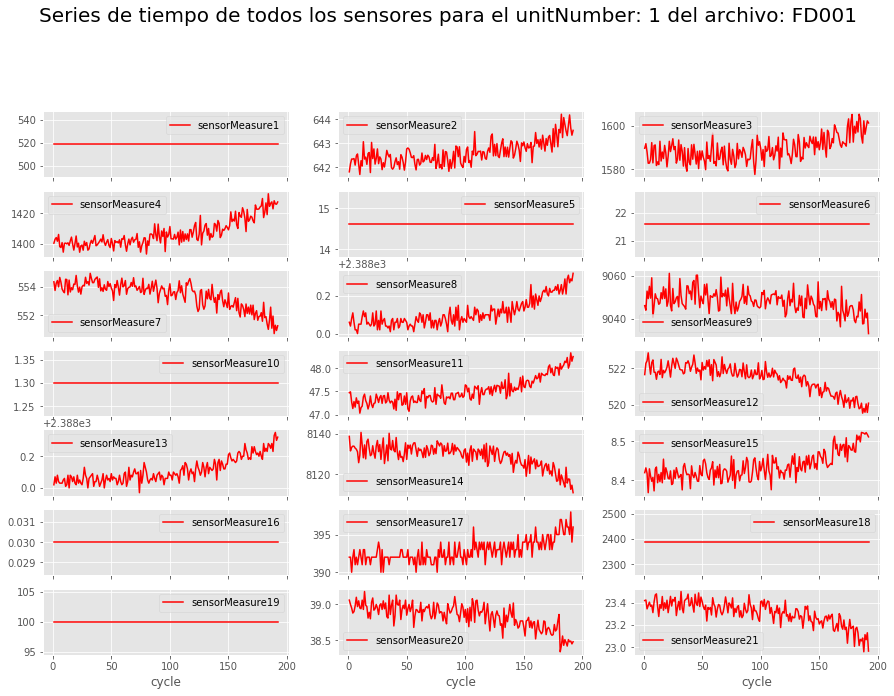

In [12]:
time_series(df_train,'FD001', 1)

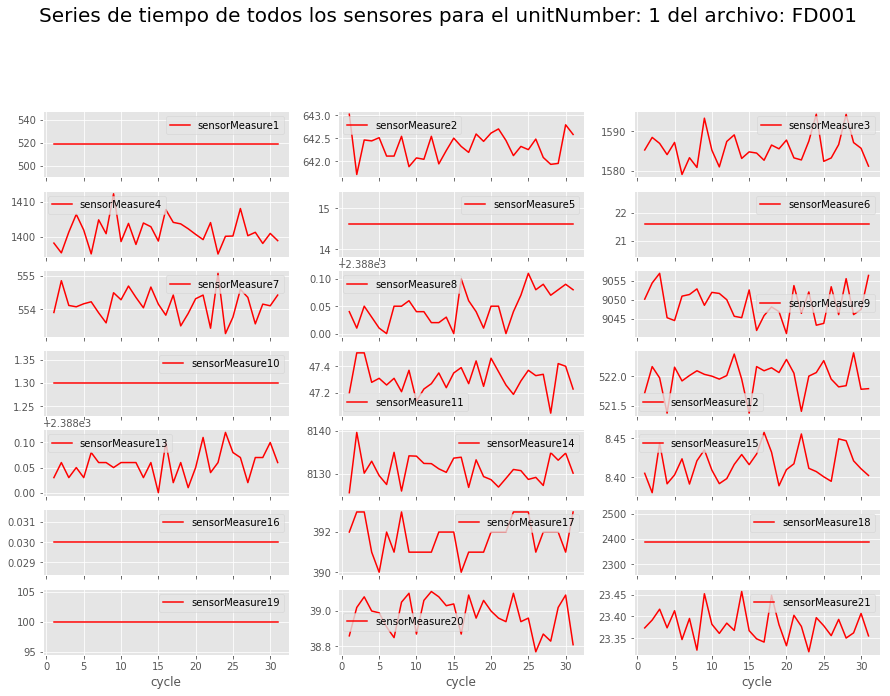

In [13]:
time_series(df_test, 'FD001', 1)

# Análisis exploratorio de los datos:

In [14]:
# Datos estadísticos de la data de entrenamiento.

def estadistica(data, archivo):
    return data[data['data_id'] == archivo].drop(['data_id', 'unitNumber'], axis = 1).describe(include='all')
    
estadistica(df_train, 'FD001')

,cycle,operatingSet1,operatingSet2,operatingSet3,sensorMeasure1,sensorMeasure2,sensorMeasure3,sensorMeasure4,sensorMeasure5,sensorMeasure6,...,sensorMeasure13,sensorMeasure14,sensorMeasure15,sensorMeasure16,sensorMeasure17,sensorMeasure18,sensorMeasure19,sensorMeasure20,sensorMeasure21,rul
count,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,...,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000
mean,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,...,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,107.807862
std,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,...,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,68.880990
min,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,...,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000
25%,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,...,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000
50%,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,...,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000
75%,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,...,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,155.000000
max,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,...,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,361.000000


##### Hay 100 simulaciones, cada simulación tiene entre 1 a 362 ciclos (con un promedio de 108 ciclos por simulación). Donde, el último ciclo para cada simulación representa el ciclo donde ocurrió la falla.

In [15]:
# Datos estadísticos de la data de prueba.

estadistica(df_test, 'FD001')

,cycle,operatingSet1,operatingSet2,operatingSet3,sensorMeasure1,sensorMeasure2,sensorMeasure3,sensorMeasure4,sensorMeasure5,sensorMeasure6,...,sensorMeasure12,sensorMeasure13,sensorMeasure14,sensorMeasure15,sensorMeasure16,sensorMeasure17,sensorMeasure18,sensorMeasure19,sensorMeasure20,sensorMeasure21
count,13096.000000,13096.000000,13096.000000,13096.0,1.309600e+04,13096.000000,13096.000000,13096.000000,1.309600e+04,13096.000000,...,13096.000000,13096.000000,13096.000000,13096.000000,1.309600e+04,13096.000000,13096.0,13096.0,13096.000000,13096.000000
mean,76.836515,-0.000011,0.000004,100.0,5.186700e+02,642.475088,1588.099204,1404.735362,1.462000e+01,21.609701,...,521.747724,2388.071025,8138.947817,8.425844,3.000000e-02,392.571625,2388.0,100.0,38.892502,23.335743
std,53.057749,0.002203,0.000294,0.0,6.014263e-11,0.400899,5.003274,6.688309,2.671743e-12,0.001704,...,0.559627,0.056934,10.188605,0.029009,8.823140e-15,1.233577,0.0,0.0,0.141681,0.084120
min,1.000000,-0.008200,-0.000600,100.0,5.186700e+02,641.130000,1569.040000,1384.390000,1.462000e+01,21.600000,...,519.380000,2387.890000,8108.500000,8.332800,3.000000e-02,389.000000,2388.0,100.0,38.310000,22.935400
25%,33.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.197500,1584.600000,1399.950000,1.462000e+01,21.610000,...,521.380000,2388.030000,8132.310000,8.405600,3.000000e-02,392.000000,2388.0,100.0,38.800000,23.281600
50%,69.000000,0.000000,0.000000,100.0,5.186700e+02,642.460000,1587.990000,1404.440000,1.462000e+01,21.610000,...,521.780000,2388.070000,8138.390000,8.424900,3.000000e-02,393.000000,2388.0,100.0,38.900000,23.339200
75%,113.000000,0.001500,0.000300,100.0,5.186700e+02,642.740000,1591.362500,1409.050000,1.462000e+01,21.610000,...,522.150000,2388.110000,8144.360000,8.444300,3.000000e-02,393.000000,2388.0,100.0,38.990000,23.393600
max,303.000000,0.007800,0.000700,100.0,5.186700e+02,644.300000,1607.550000,1433.360000,1.462000e+01,21.610000,...,523.760000,2388.320000,8220.480000,8.541400,3.000000e-02,397.000000,2388.0,100.0,39.410000,23.641900


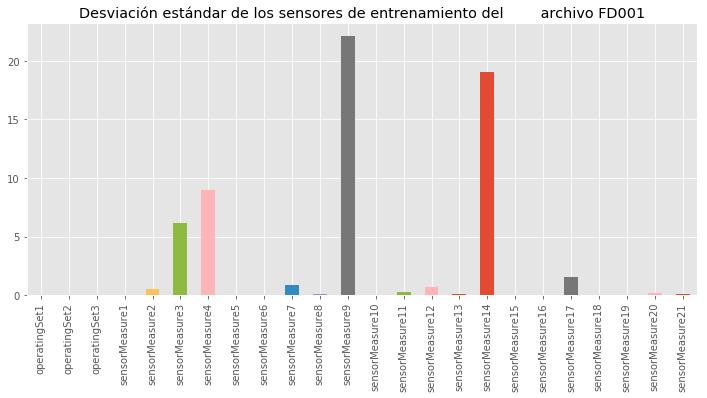

In [16]:
def desviacion(data, archivo, i, j):
    
    a = data[(data['data_id'] == archivo) & data['unitNumber'] == j]
    a = a[settings+sensors]
    
    if i == 0:
        a.std().plot(kind='bar', figsize=(12, 5), title = 'Desviación estándar de los sensores de entrenamiento del\
        archivo ' + archivo)
        plt.show()
    else:
        a.std().plot(kind='bar', figsize=(12, 5), title = 'Desviación estándar de los sensores de prueba del\
        archivo '+ archivo)
        plt.show()
    
desviacion(df_train, 'FD001', 0, 1)

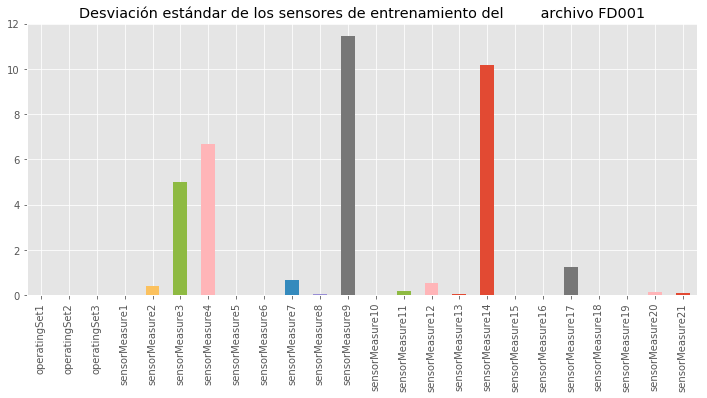

In [17]:
desviacion(df_test, 'FD001', 0, 1)
sns.reset_orig()

##### Con estas graficas se evidencia que hay sensores, como el s9, con datos altamente dispersos con respecto a su promedio.

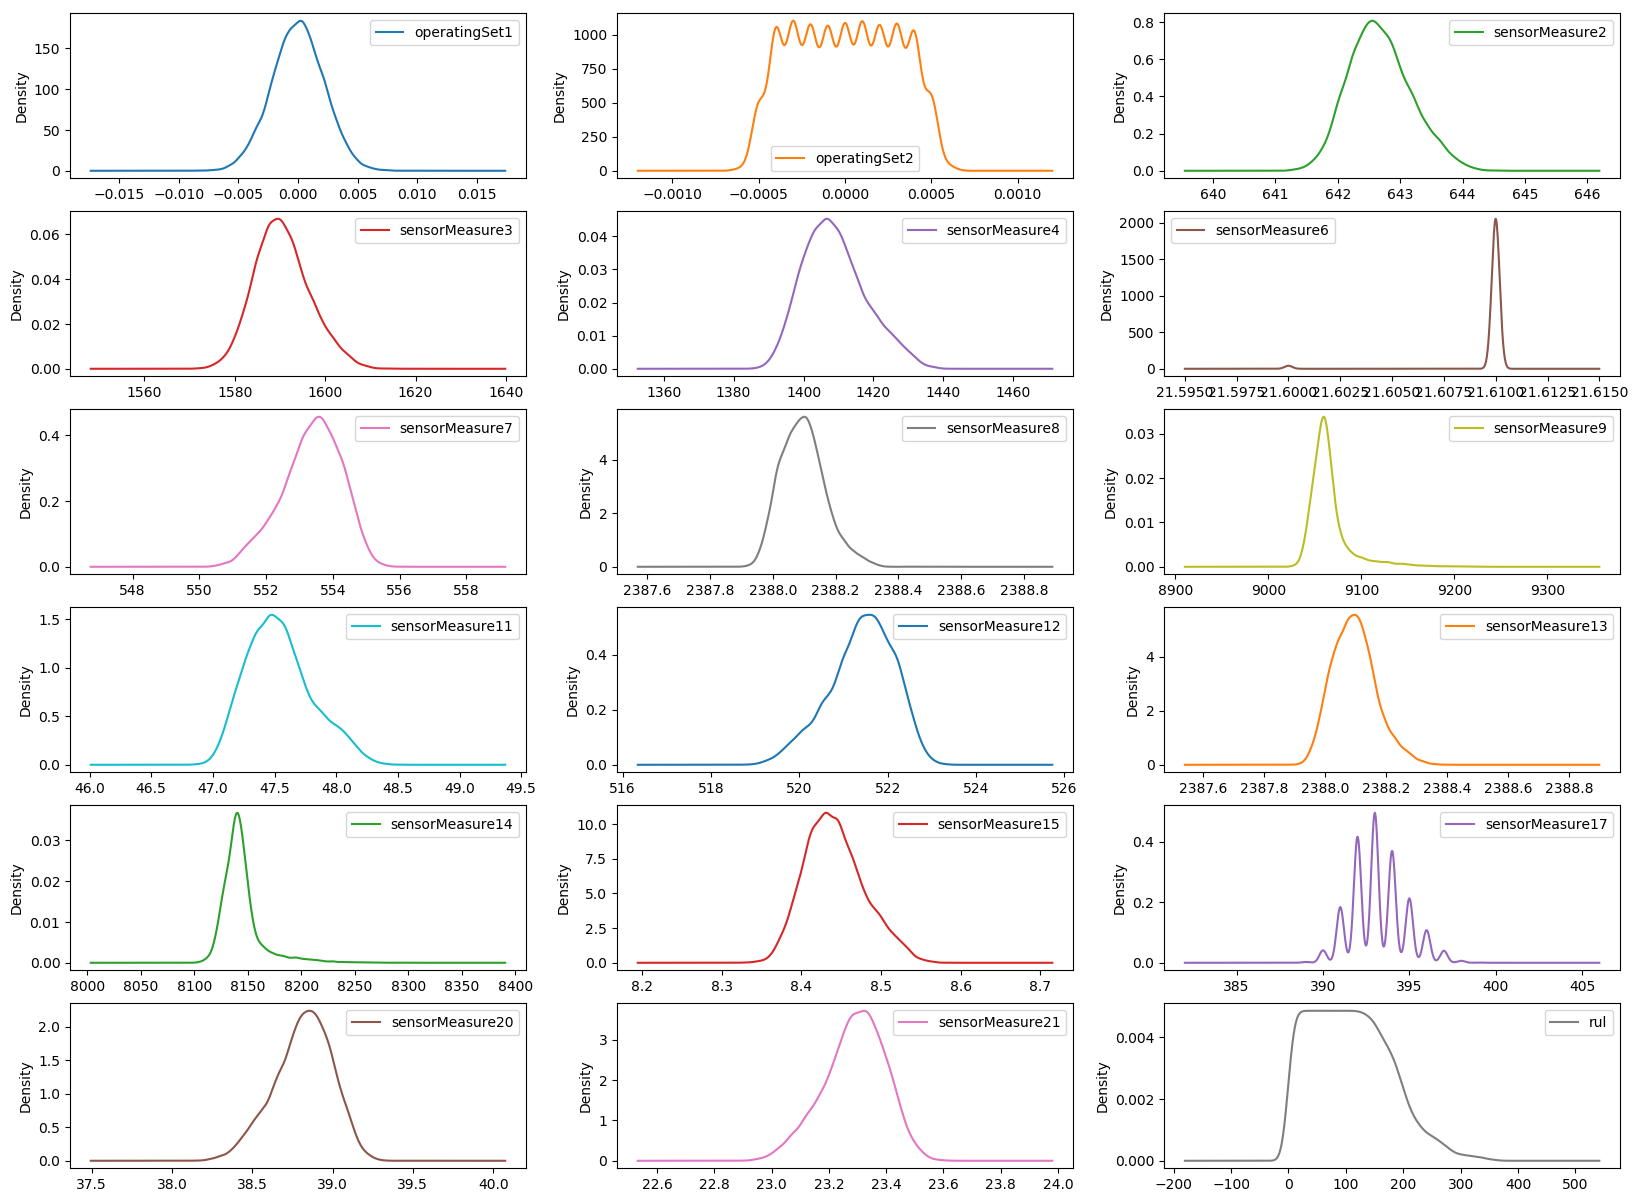

In [18]:
# Distribución de los atributos

def distribucion(data, archivo):
    a = data[data['data_id'] == archivo]
    
    if archivo == 'FD001':
        a.drop(['data_id', 'unitNumber', 'cycle'], axis=1).loc[:, a.std()>0.00001].plot(kind='density',
        layout = (6,3), subplots=True, sharex=False, figsize=(20,15))
        plt.show()
        
    if archivo == 'FD002':
        a.drop(['data_id', 'unitNumber', 'cycle'], axis=1).loc[:, a.std()>0.00001].plot(kind='density',
        layout = (5,5), subplots=True, sharex=False, figsize=(20,15))
        plt.show()
        
    if archivo == 'FD003':
        a.drop(['data_id', 'unitNumber', 'cycle'], axis=1).loc[:, a.std()>0.00001].plot(kind='density',
        layout = (5,4), subplots=True, sharex=False, figsize=(20,15))
        plt.show()
        
    if archivo == 'FD004':
        a.drop(['data_id', 'unitNumber', 'cycle'], axis=1).loc[:, a.std()>0.00001].plot(kind='density',
        layout = (5,5), subplots=True, sharex=False, figsize=(20,15))
        plt.show()

distribucion(df_train, 'FD001')

#### Como algunos sensores presentan comportamientos fuera de la distribución normal. Se emplearan métodos no paramétricos para seguir el estudio de los datos.

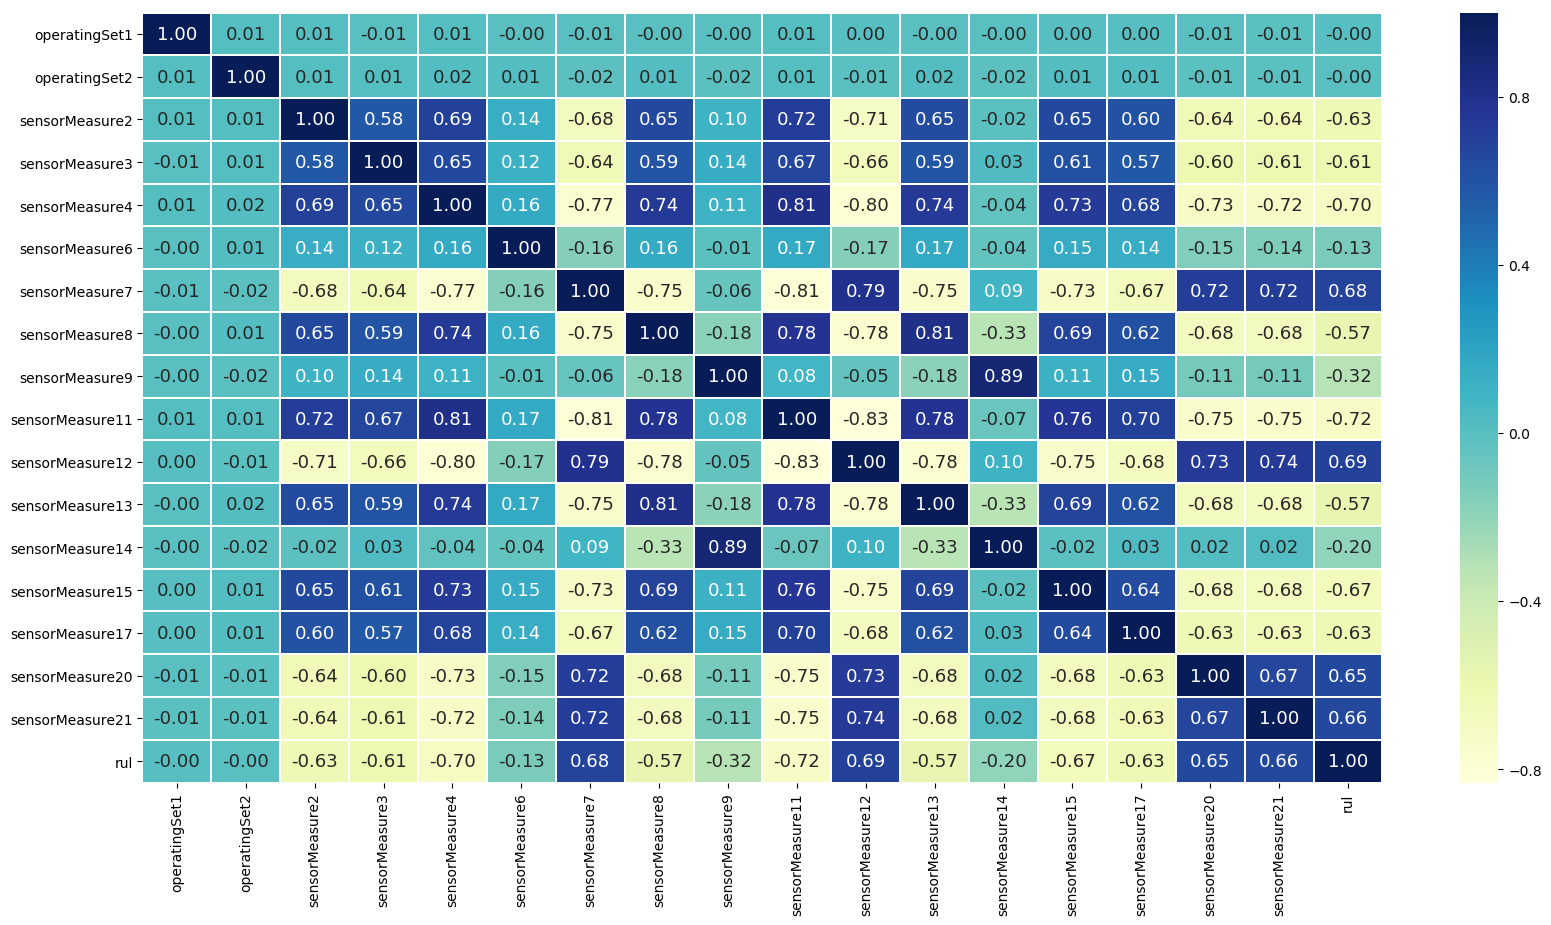

In [19]:
# Matriz de correlación no paramétrica empleando spearman... ENTRENAMIENTO
from scipy.stats import spearmanr

def correlacion(data, archivo):
    a = data[data['data_id'] == archivo]

    coef, p = spearmanr(a.drop(['data_id', 'unitNumber', 'cycle'], axis=1).loc[:, a.std()>0.00001])
    
    columnas = list(a.drop(['data_id', 'unitNumber', 'cycle'], axis=1).loc[:, a.std()>0.00001].columns.values)
    df = pd.DataFrame(coef, columns=columnas)
   
    plt.figure(figsize=(20,10))
    g = sns.heatmap(df, annot= True, fmt='0.2f', annot_kws={'size': 13}, linewidths=.7, 
                cmap="YlGnBu", xticklabels=True, yticklabels=True )
    
    g.set_yticklabels(g.get_xticklabels(), rotation =0)
    g.set_xticklabels(g.get_xticklabels(), rotation =90)
    
    plt.show()
    
correlacion(df_train,'FD001')

Para el primer archivo de entrenamiento (FD001) hay una correlación muy alta (> 0.8) entre algunas características:


**(s14, s9), (s11, s4), (s11, s7), (s11, s12), (s4, s12), (s8, s13), (s7, s12)**


Esto puede perjudicar el rendimiento de algunos algoritmos ML.

Esto se puede ampliar al resto de archivos (FD002/003/004) de igual manera. Por ahora, solo hice el comentario para el primer archivo.

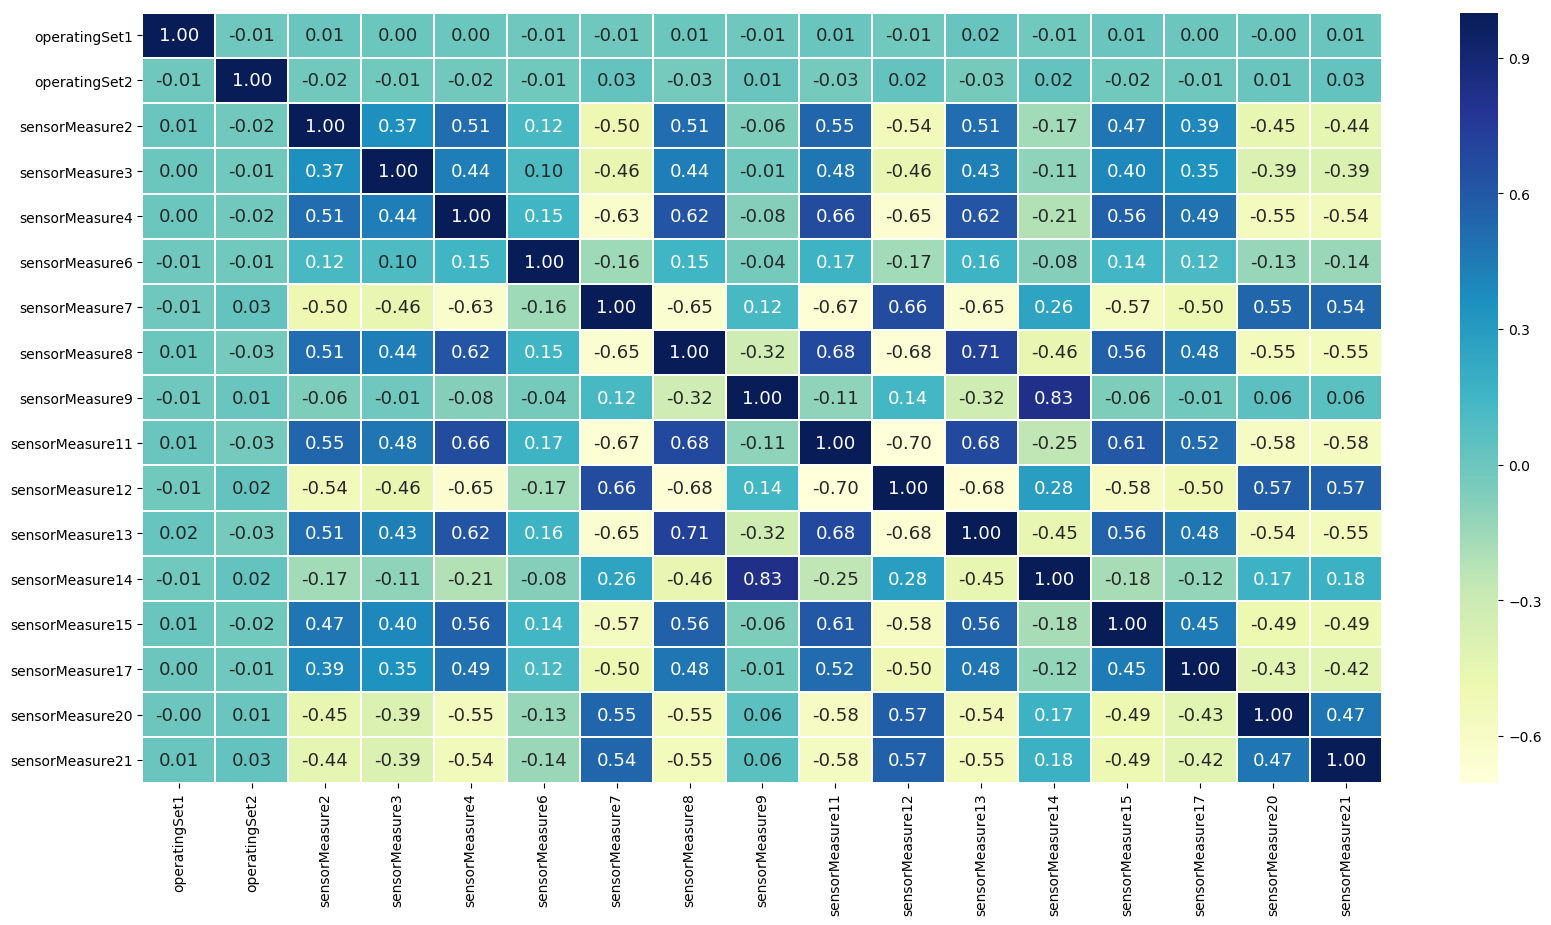

In [20]:
# Matriz de correlación no paramétrica empleando spearman... ENTRENAMIENTO

correlacion(df_test, 'FD001')

In [21]:
def explorar(data, archivo, sensor, unit):
    
    """Se muestran 4 graficas representativas de los datos.
    
    plot1: histograma
    plot2: boxplot 
    plot3: line plot (serie de tiempo vs. cycle)
    plot4: scatter plot vs. RUL
        
    Args:
        data (DataFrame): DataFrame de entrenamiento o prueba.
        archivo (str): Archivo a graficar (FD001/002/003/004).
        sensor (str): Columna del sensor de interes.
        unit (int): número de unidades por sensor a graficar.
    Returns:
        plots
    
    """
        
    plt.style.use('_classic_test')
    a = data[data['data_id'] == archivo]
    
    fig = plt.figure(figsize=(10, 8))

    sub1 = fig.add_subplot(221) 
    sub1.set_title('histograma: '+archivo +'-'+ sensor) 
    sub1.hist(a[sensor])

    sub2 = fig.add_subplot(222)
    sub2.set_title('boxplot: '+archivo +'-'+sensor)
    sub2.boxplot(a[sensor])
    
    select_engines = list(pd.unique(a.unitNumber))
    select_engines = np.random.choice(range(1,len(select_engines)+1), unit, replace=False)
        
    sub3 = fig.add_subplot(223)
    sub3.set_title('Series de tiempo: ' + archivo +'-'+ sensor + ' / cycle')
    sub3.set_xlabel('cycle')
    
    for i in select_engines:
        df = a[['cycle', sensor]][a.unitNumber == i]
        sub3.plot(df['cycle'], df[sensor])
    
    sub4 = fig.add_subplot(224)
    sub4.set_title("Scatter: "+ archivo +'-'+ sensor + " / RUL")
    sub4.set_xlabel('RUL')
    sub4.scatter(a['rul'], a[sensor])

    plt.tight_layout()
    plt.show()
    sns.reset_orig()

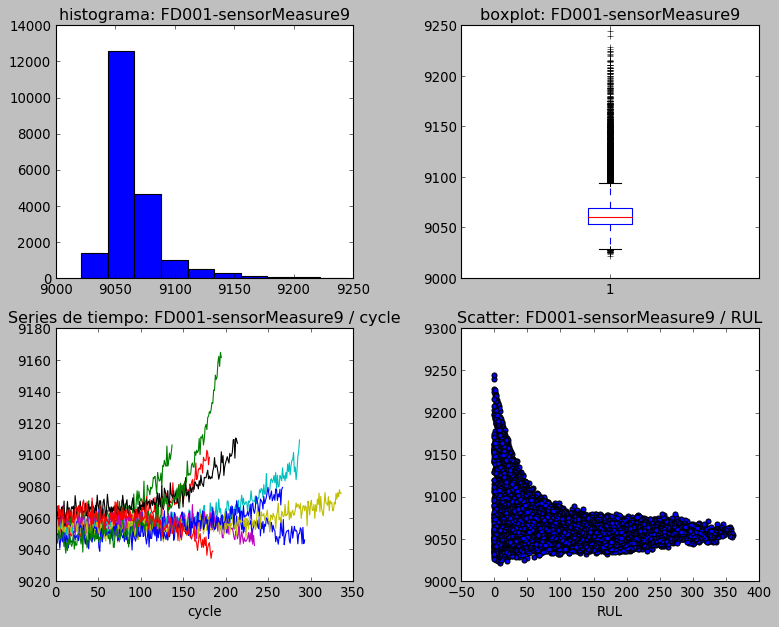

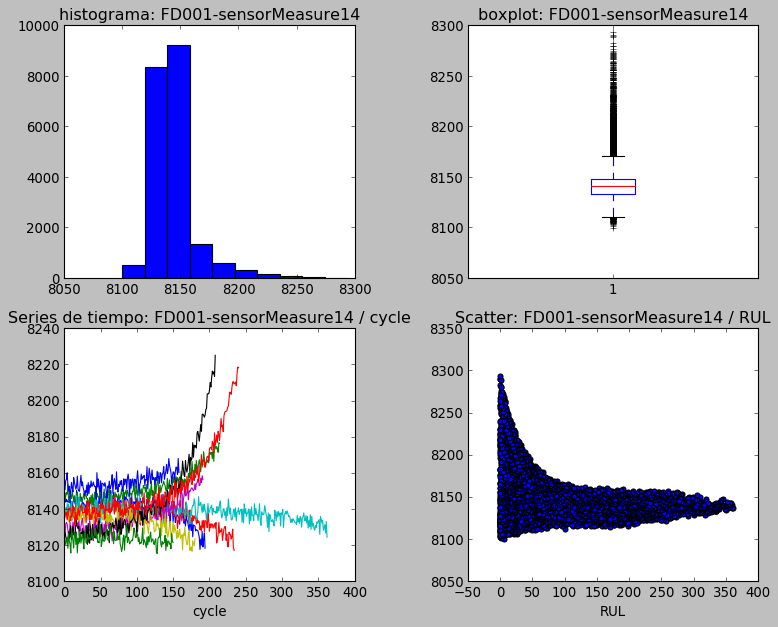

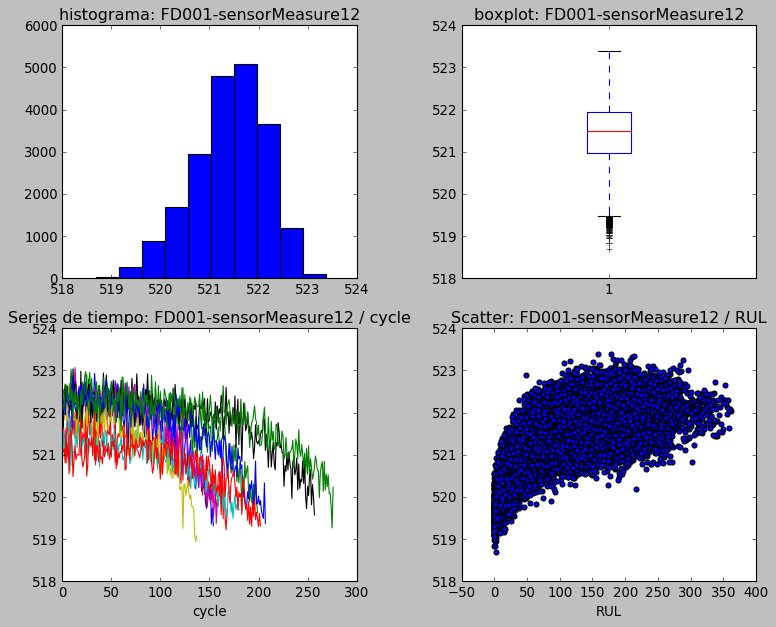

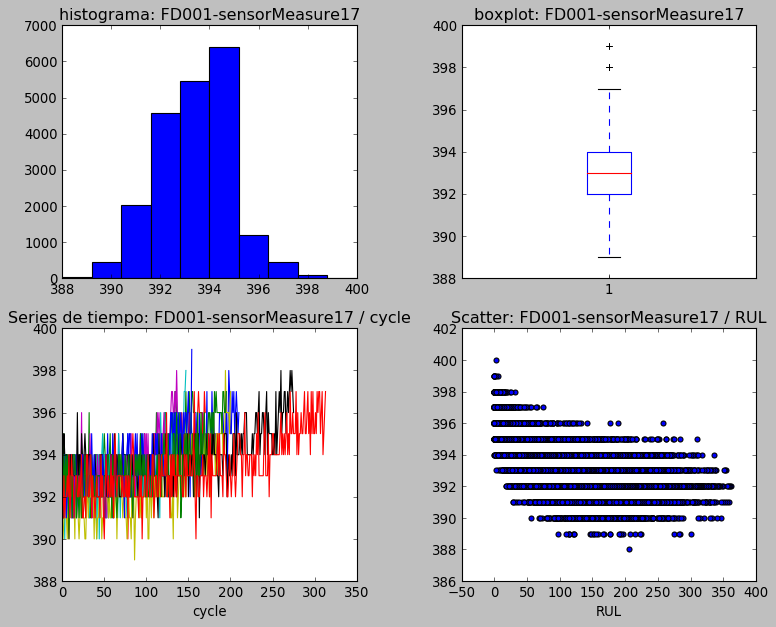

In [22]:
explorar(df_train, 'FD001', "sensorMeasure9", 10)
explorar(df_train, 'FD001', "sensorMeasure14", 10)
explorar(df_train, 'FD001', "sensorMeasure12", 10)
explorar(df_train, 'FD001', "sensorMeasure17", 10)

# Normalización de datos

C:\Users\Porti\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


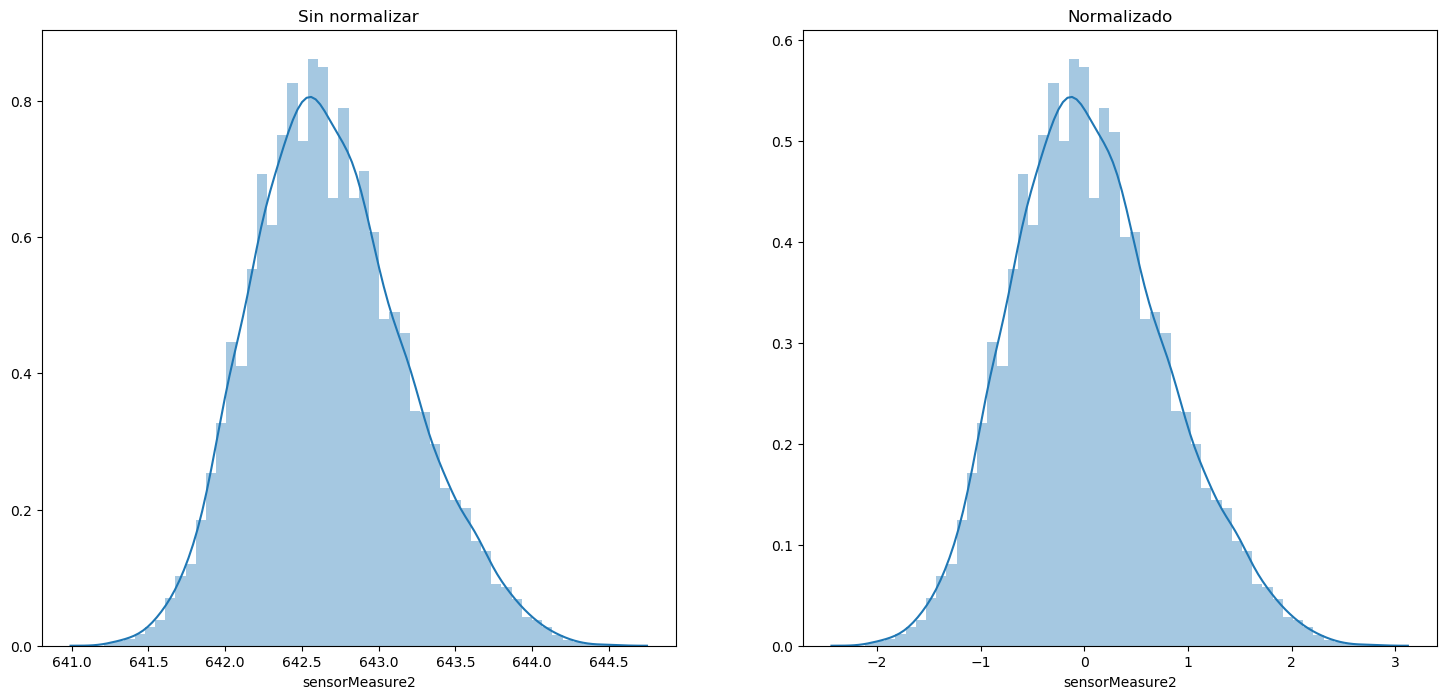

In [23]:
scaler = preprocessing.RobustScaler() #Aplico un proceso de escalamiento robusto ya que es apropiado para data con outliers

def normalizacion(data, archivo, sensor):
    a = data[data['data_id'] == archivo].drop(['data_id', 'unitNumber', 'cycle', 'rul'] + settings, axis = 1)
    normalizado = scaler.fit_transform(a) #Indico a que data se le hará el escalamiento. Salida: np.array
    df_normalizado = pd.DataFrame(normalizado, columns= sensors) #Convierto dicho array en un DF.

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize= (18,8))

    ax1.set_title('Sin normalizar')
    sns.distplot(a[sensor], ax=ax1)

    ax2.set_title('Normalizado')
    sns.distplot(df_normalizado[sensor], ax=ax2)
    plt.show()

normalizacion(df_train, 'FD001', 'sensorMeasure2')

# Clustering

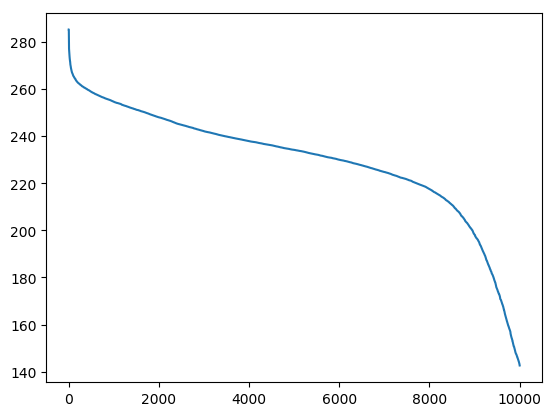

In [24]:
#Gráfica knee para DBSCAN
a = df_train[df_train['data_id'] == 'FD001'].drop(['data_id', 'unitNumber', 'cycle', 'rul'] + settings, axis = 1)
datas1 = a.head(10000)

from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=len(datas1)).fit(datas1)
distances, indices = nbrs.kneighbors(datas1)

d = distances[:,-1]
c = sorted(d, reverse=True)
plt.plot(list(range(1,len(c)+1)), c)

In [25]:
"""from collections import Counter

#Aplico el algoritmo de clustering DBSCAN.

def dbscan(data, archivo, eps, min_samples):
    
    a = data[data['data_id'] == archivo].drop(['data_id', 'unitNumber', 'cycle', 'rul'] + settings, axis = 1)
    ss = preprocessing.StandardScaler()
    X = ss.fit_transform(a)
    fit = DBSCAN(eps, min_samples, n_jobs=-1).fit(X)
    print(fit)
    print('\n')

    fitted_labels = fit.labels_ #Almaceno las etiquetas de los clusters en la variable fitted_labels.
    n_cluster = len(set(fitted_labels)) - (1 if -1 in fitted_labels else 0) #Calculo el # de cluster quitando los outliers.

    outliers_df = pd.DataFrame(a) #Creo un DF con solo los sensores para almacenar los outliers.
    outliers_df = outliers_df.loc[:, outliers_df.std() > 0.00001] #Remuevo las columnas con desviación estándar igual a cero.

    print(Counter(fitted_labels)) #Cuento cuantos elementos tiene cada cluster.
    print('\n')

    print('El numero de cluster estimados es: %d ' % n_cluster)

    print('\n')
    print('Estos son los outliers detectados por el algoritmo DBSCAN:')
    print('\n')
    print(outliers_df[fitted_labels == -1]) #Imprimo SOLO los outliers del DBSCAN.

dbscan(df_train, 'FD001', 100, 100)"""

"from collections import Counter\n\n#Aplico el algoritmo de clustering DBSCAN.\n\ndef dbscan(data, archivo, eps, min_samples):\n    \n    a = data[data['data_id'] == archivo].drop(['data_id', 'unitNumber', 'cycle', 'rul'] + settings, axis = 1)\n    ss = preprocessing.StandardScaler()\n    X = ss.fit_transform(a)\n    fit = DBSCAN(eps, min_samples, n_jobs=-1).fit(X)\n    print(fit)\n    print('\n')\n\n    fitted_labels = fit.labels_ #Almaceno las etiquetas de los clusters en la variable fitted_labels.\n    n_cluster = len(set(fitted_labels)) - (1 if -1 in fitted_labels else 0) #Calculo el # de cluster quitando los outliers.\n\n    outliers_df = pd.DataFrame(a) #Creo un DF con solo los sensores para almacenar los outliers.\n    outliers_df = outliers_df.loc[:, outliers_df.std() > 0.00001] #Remuevo las columnas con desviación estándar igual a cero.\n\n    print(Counter(fitted_labels)) #Cuento cuantos elementos tiene cada cluster.\n    print('\n')\n\n    print('El numero de cluster estimad

# Suavizado de señal

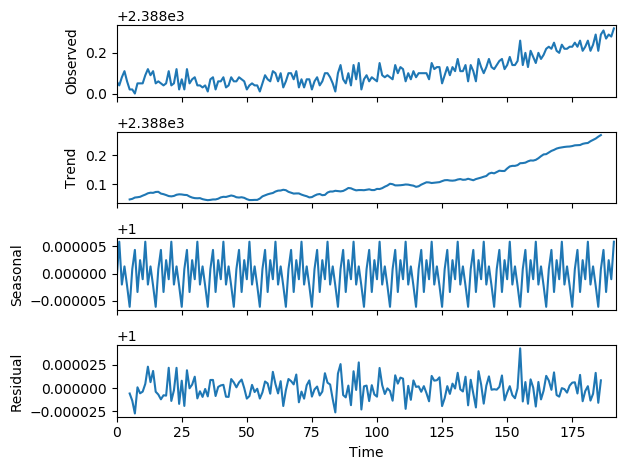

In [26]:
s2_1_cycle = df_train[df_train['data_id'] == 'FD001'].drop(['data_id', 'cycle'], axis = 1).loc[df_train['unitNumber'] 
== 1, 'sensorMeasure8']

s2_1_cycle.reset_index(drop=True, inplace=True)

from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(s2_1_cycle.values, freq=10, model='multiplicative')
resplot = res.plot()

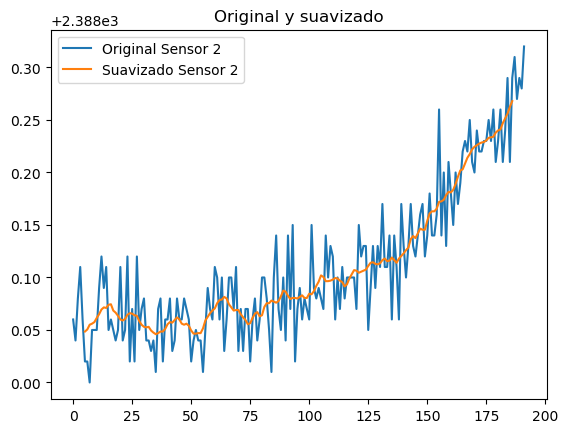

In [27]:
# Graficando data original y sin ruido
trend = res.trend
seasonal = res.seasonal
residual = res.resid

line_1, = plt.plot(s2_1_cycle, label='line 1')
line_2, = plt.plot(trend, label='line 2')
plt.title('Original y suavizado')
plt.legend([line_1, line_2], ['Original Sensor 2', 'Suavizado Sensor 2'])

C:\Users\Porti\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


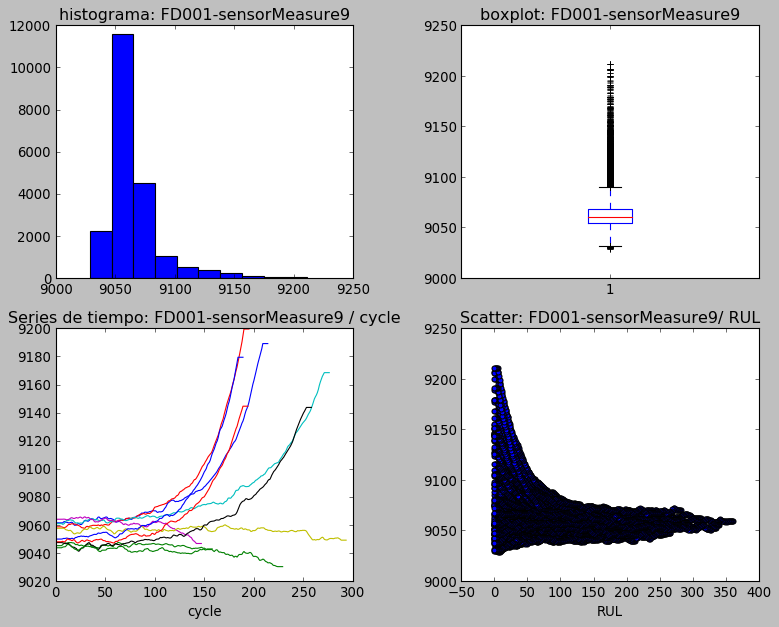

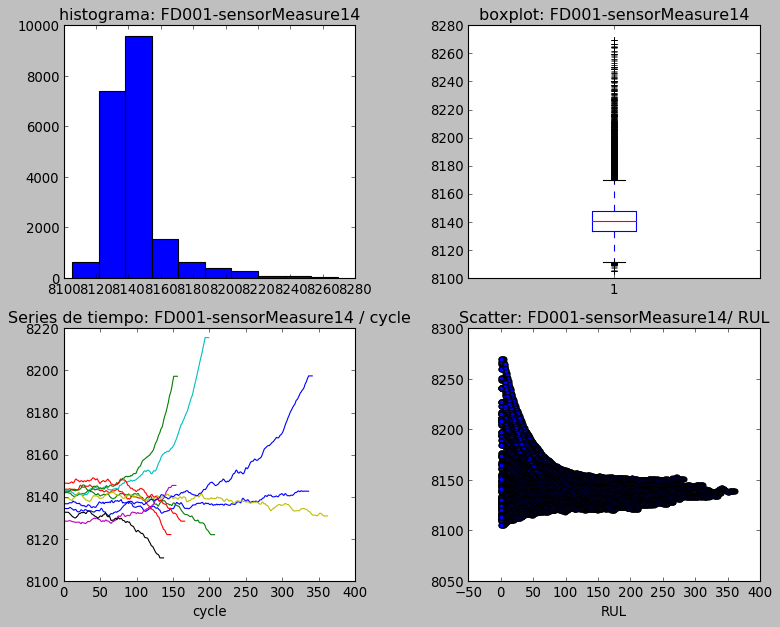

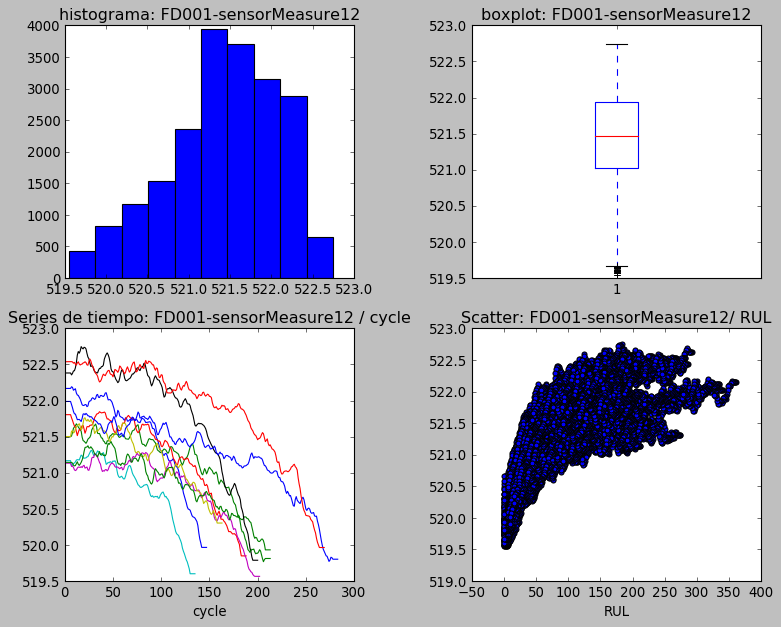

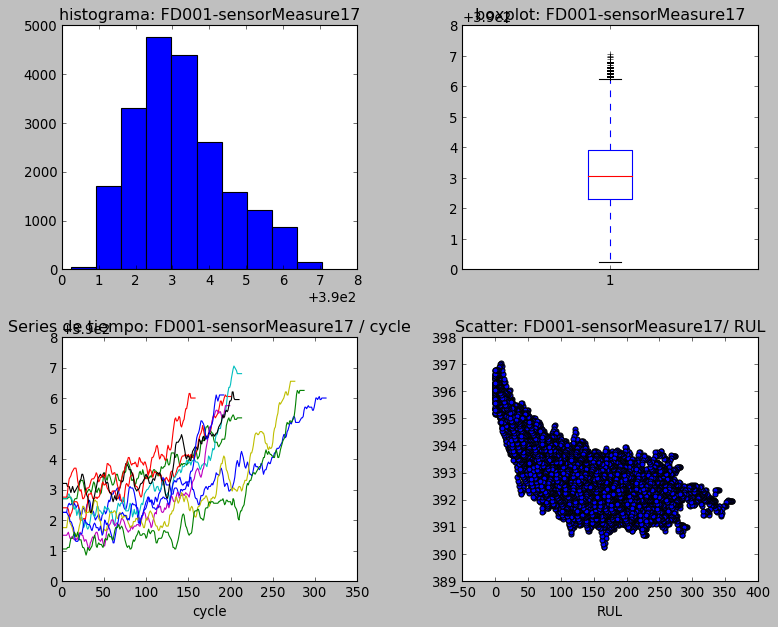

In [28]:
def f(col):
    smooth_col = seasonal_decompose(col.values, freq=10).trend
    return smooth_col

def explorar_suavizado(data, archivo, sensor, unit):
    a = data[data['data_id'] == archivo]
    transformed = a.drop(['data_id', 'cycle', 'rul'] + settings, axis=1).groupby('unitNumber').transform(f)
    transformed['unitNumber'] = a['unitNumber']

    df_1 = a[['unitNumber', 'cycle',]+settings]
    df_2 = transformed.groupby('unitNumber').ffill().bfill().drop('unitNumber', axis=1)
    df_3 = a['rul']
    train = pd.concat([df_1, df_2, df_3], axis=1)

    plt.style.use('_classic_test')
    fig = plt.figure(figsize=(10, 8))

    sub1 = fig.add_subplot(221) 
    sub1.set_title('histograma: '+archivo +'-'+ sensor) 
    sub1.hist(train[sensor])

    sub2 = fig.add_subplot(222)
    sub2.set_title('boxplot: '+archivo +'-'+ sensor)
    sub2.boxplot(train[sensor])

    select_engines = list(pd.unique(train.unitNumber))
    select_engines = np.random.choice(range(1,len(select_engines)+1), unit, replace=False)

    sub3 = fig.add_subplot(223)
    sub3.set_title('Series de tiempo: '+ archivo +'-'+ sensor+' / cycle')
    sub3.set_xlabel('cycle')

    for i in select_engines:
        df = train[['cycle', sensor]][train.unitNumber == i]
        sub3.plot(df['cycle'], df[sensor])

    sub4 = fig.add_subplot(224)
    sub4.set_title('Scatter: ' +archivo +'-'+ sensor+ '/ RUL')
    sub4.set_xlabel('RUL')
    sub4.scatter(train['rul'], train[sensor])

    plt.tight_layout()
    plt.show()
    sns.reset_orig()
    
explorar_suavizado(df_train, 'FD001', 'sensorMeasure9', 10)
explorar_suavizado(df_train, 'FD001', 'sensorMeasure14', 10)
explorar_suavizado(df_train, 'FD001', 'sensorMeasure12', 10)
explorar_suavizado(df_train, 'FD001', 'sensorMeasure17', 10)

Se graficaron los mismos sensores que antes pero esta vez suavizados, esto con la finalidad de poder comparar los graficos cuando la data esta suavizada y cuando no lo está... Se observa un cambio significativo en las curvas de __[Sensores vs cycle]__ y en la curva de __[Sensores vs RUL]__, especificamente en el __sensor 17__ se evidencia un cambio notable en estas graficas mencionadas anteriormente.

# Fourier

C:\Users\Porti\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


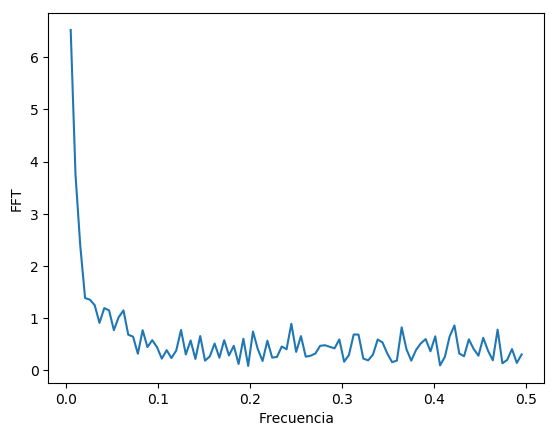

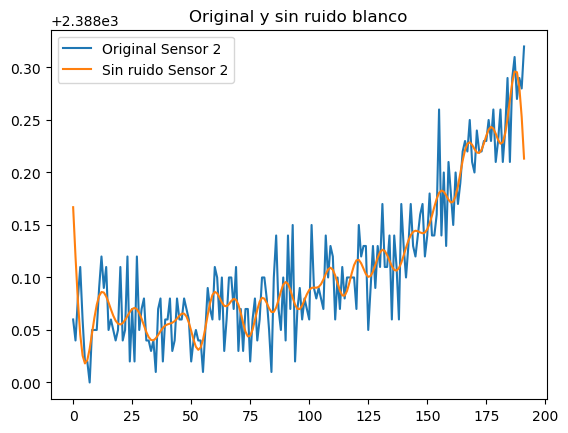

In [29]:
from scipy import fftpack
sample_freq = fftpack.fftfreq(s2_1_cycle.size, d=1)
sig_fft = fftpack.fft(s2_1_cycle)
pidxs = np.where(sample_freq > 0)
freqs = sample_freq[pidxs]
power = np.abs(sig_fft)[pidxs]

#Grafico de la frecuencia
plt.figure(1)
plt.xlabel('Frecuencia')
plt.ylabel('FFT')
plt.plot(freqs, power)

# filtrando el ruido y graficando
freq = freqs[power.argmax()]
sig_fft[np.abs(sample_freq) > freq*20] = 0
s2_1_cycle_smooth = fftpack.ifft(sig_fft)

plt.figure(2)
line_1, = plt.plot(s2_1_cycle, label='line 1')
line_2, = plt.plot(s2_1_cycle_smooth, label='line 2')
plt.title('Original y sin ruido blanco')
plt.legend([line_1, line_2], ['Original Sensor 2', 'Sin ruido Sensor 2'])

# Resumen:

* Hay una correlación muy alta (> 0,8) entre algunas características, por ejemplo (s14 y s9), (s11 y s4), (s11 y s7), (s11 y s12), (s4 y s12), (s8 y s13), (s7 y s12). Esta correlación puede afectar el rendimiento de algunos algoritmos de aprendizaje automático. Por lo tanto, parte de estas características se deberian eliminar en la selección de características durante la fase de modelado.

* La mayoría de las características tienen una relación no lineal con el RUL.

* La mayoría de las características muestran una distribución normal que probablemente mejorará el rendimiento de los modelos.

C:\Users\Porti\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


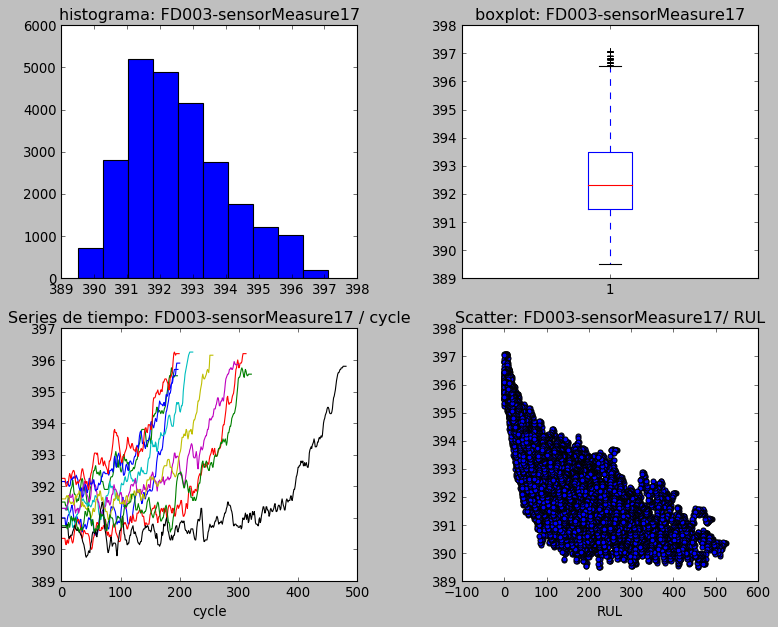

In [30]:
explorar_suavizado(df_train, 'FD003', 'sensorMeasure17', 10)

In [31]:
a = df_train_fd001[df_train_fd001['unitNumber'] == 1]
a = a.drop(['data_id', 'unitNumber']+settings, axis = 1)

C:\Users\Porti\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


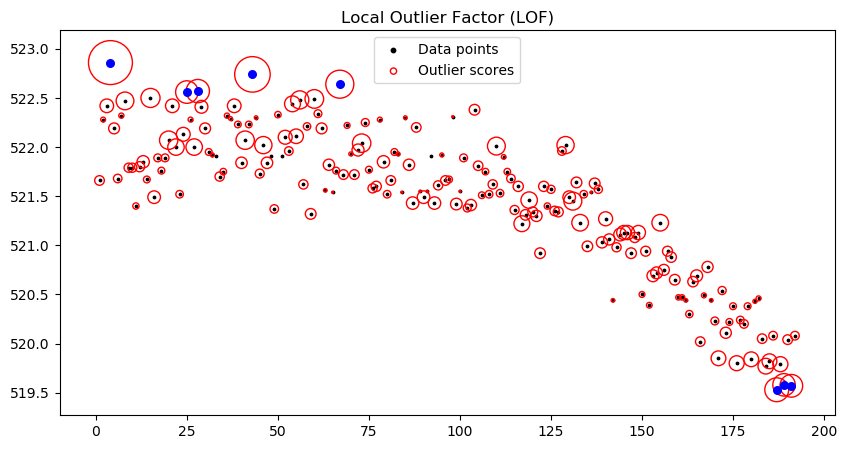

Posibles valores outliers del sensor

4.0 522.86
25.0 522.56
28.0 522.57
43.0 522.74
67.0 522.64
187.0 519.53
189.0 519.58
191.0 519.57


Score de los posibles outliers 

-2.730961071409853
-1.418280090011947
-1.4486885560037739
-2.1134245139959607
-1.6736636322011411
-1.4747645102659444
-1.4126934561736926
-1.4251076669921148


In [55]:
from sklearn.neighbors import LocalOutlierFactor #Importo el paquete

def outliers_lof(sensor):
    b = a[sensor].values.reshape(-1,1)     #Convierto el vector columna en un vector fila.
    clf = LocalOutlierFactor(n_neighbors=15)
    clf.fit(b)
    X_scores = clf.negative_outlier_factor_
    
    plt.figure(figsize=(10,5))
    
    #Dibujo los puntos originales del sensor
    plt.title("Local Outlier Factor (LOF)")
    plt.scatter(a['cycle'], a[sensor], color='k', s=3., label='Data points')

    # Se dibujo un circulo que sea proporcional al score del outlier.
    radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
    plt.scatter(a['cycle'], a[sensor], s=1000 * radius, edgecolors='r', facecolors='none', label='Outlier scores')

    [plt.scatter(a['cycle'][i], a[sensor][i], s=30, c = 'b') 
    for i in list(range(1,192)) if (X_scores[i]<= -1.3) or (X_scores[i]>= -0.8)]

    plt.axis('tight')

    legend = plt.legend(loc='upper center')
    legend.legendHandles[0]._sizes = [10]
    legend.legendHandles[1]._sizes = [20]
    plt.show()
    
    # Valores que posiblemente sean outliers
    print('Posibles valores outliers del sensor\n')
    e = [print(a['cycle'][i], a[sensor][i]) for i in list(range(1,192)) 
     if (X_scores[i]<= -1.3) or (X_scores[i]>= -0.8)]
    
    print('\n')
    
    # Score de los posibles outliers
    print('Score de los posibles outliers \n')
    score_outlier = [print(i) for i in X_scores if (i <= -1.3) or (i >= -0.8)]

outliers_lof('sensorMeasure12')

#np.asarray(e).shape